# Librerias & Recursos

In [2]:
%pip install pandas numpy unidecode nltk spacy matplotlib wordcloud scikit-learn

# Descargar el modelo de lenguaje de spaCy
!python -m spacy download en_core_web_sm

%pip install openpyxl


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.9 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import nltk
import spacy
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import nltk
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings('ignore')

In [2]:
# Asegurarse de que tengamos los recursos necesarios para NLTK
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [5]:
# Install pyarrow for parquet support
%pip install pyarrow


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Carga de Datasets

In [3]:
twitter_df = pd.read_csv('Data/Tweet_Post.csv')
twitter_df.head()

,user,text,date,emotion,sentiment
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed,scared
1,@shpiderduck,me siento abrumado,"Jan 6, 2024 · 2:35 AM UTC",overwhelmed,scared
2,@Alex_R_art,Me siento un poco abrumado por la cantidad de ...,"Jan 6, 2024 · 12:20 AM UTC",overwhelmed,scared
3,@anggelinaa97,Salvador la única persona que no la ha abrumad...,"Jan 5, 2024 · 10:38 PM UTC",overwhelmed,scared
4,@diegoreyesvqz,Denme un helado o algo que ando full abrumado.,"Jan 5, 2024 · 8:38 PM UTC",overwhelmed,scared


In [4]:
# cargar dataset parquet en pandas
parquet_file = pd.read_parquet('Data/test-00000-of-00001-d161e0d7d20a9b0a.parquet')
travel_df = pd.DataFrame(parquet_file)
travel_df.head()

,text,label
0,Un agradable paseo por el casco antiguo de la ...,5
1,Gran llegar entrada procedente Gran ciudad en ...,4
2,Sencillamente Espectacular Para Caminarlo o en...,5
3,Monserrate y sus bellas vistas Es una visita o...,5
4,Un paraiso muy cerca de la ciudad de Mérida El...,5


# Descripción de los datos

In [5]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590 entries, 0 to 2589
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user       2590 non-null   object
 1   text       2590 non-null   object
 2   date       2590 non-null   object
 3   emotion    2590 non-null   object
 4   sentiment  2590 non-null   object
dtypes: object(5)
memory usage: 101.3+ KB


In [6]:
travel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25171 entries, 0 to 25170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25171 non-null  object
 1   label   25171 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 393.4+ KB


# Pre procesamiento

## Mapear etiquetas de sentimentos segun el modelo de Sentimiento de Plutchik

In [7]:
twitter_selected = twitter_df[['text', 'sentiment']].copy()
twitter_selected.rename(columns={'text': 'post'}, inplace=True)
twitter_selected['source'] = 'Twitter'
twitter_selected.head()

,post,sentiment,source
0,termine bien abrumado después de hoy,scared,Twitter
1,me siento abrumado,scared,Twitter
2,Me siento un poco abrumado por la cantidad de ...,scared,Twitter
3,Salvador la única persona que no la ha abrumad...,scared,Twitter
4,Denme un helado o algo que ando full abrumado.,scared,Twitter


In [8]:
travel_selected = travel_df.copy()
travel_selected.rename(columns={'text': 'post', 'label': 'sentiment'}, inplace=True)
travel_selected['source'] = 'Review'
travel_selected.head()

,post,sentiment,source
0,Un agradable paseo por el casco antiguo de la ...,5,Review
1,Gran llegar entrada procedente Gran ciudad en ...,4,Review
2,Sencillamente Espectacular Para Caminarlo o en...,5,Review
3,Monserrate y sus bellas vistas Es una visita o...,5,Review
4,Un paraiso muy cerca de la ciudad de Mérida El...,5,Review


In [9]:
travel_selected.shape

(25171, 3)

In [10]:
# 2 registros del dataset de la columna post, donde sentiment = 1, que se vea completo la columna post
display(travel_selected[travel_selected['sentiment'] == 1].head(2))
display(travel_selected[travel_selected['sentiment'] == 2].head(2))
display(travel_selected[travel_selected['sentiment'] == 3].head(2))
display(travel_selected[travel_selected['sentiment'] == 4].head(2))
display(travel_selected[travel_selected['sentiment'] == 5].head(2))


,post,sentiment,source
43,Pésima opción entre servicio e instalaciones N...,1,Review
79,Aburrido Me enteré a través del museo entero c...,1,Review


,post,sentiment,source
11,"Buena comida, pero ten paciencia Este fue el p...",2,Review
87,"horrible sucio, descuidado, abandonado, muy fe...",2,Review


,post,sentiment,source
9,Información poco clara. Lugar agradable Cierra...,3,Review
19,Comida decepcionante Reservamos una mesa aquí ...,3,Review


,post,sentiment,source
1,Gran llegar entrada procedente Gran ciudad en ...,4,Review
8,Buen hotel para negocios La ubicacion del hote...,4,Review


,post,sentiment,source
0,Un agradable paseo por el casco antiguo de la ...,5,Review
2,Sencillamente Espectacular Para Caminarlo o en...,5,Review


In [11]:
# Mapear los sentimientos según el modelo de Plutchik
# Plutchik tiene 8 emociones básicas: alegría, confianza, miedo, sorpresa, tristeza, disgusto, ira, anticipación
plutchik_mapping = {
    # Twitter emotions
    'scared': 'miedo',
    'sad': 'tristeza',
    'powerful': 'confianza',
    'peaceful': 'serenidad',  # Podría mapearse a "confianza" en un nivel menor de intensidad
    'mad': 'ira',
    'joyful': 'alegria',   

    # Hotel ratings (1-5)
    1: 'ira',      # Rating 1: Muy negativo, muestra ira/enojo
    2: 'tristeza',    # Rating 2: Negativo, muestra disgusto, tristeza
    3: 'aceptacion',    # Rating 3: Mixto o neutral
    4: 'alegria',        # Rating 4: Positivo, muestra alegría
    5: 'confianza'       # Rating 5: Muy positivo, muestra confianza/admiración
}

# Aplicar mapping a los sentimientos en ambos datasets
twitter_selected['plutchik_sentiment'] = twitter_selected['sentiment'].map(plutchik_mapping)
travel_selected['plutchik_sentiment'] = travel_selected['sentiment'].map(plutchik_mapping)


print("\nResultados Mapeo de Twitter_df")
print(twitter_selected[['sentiment', 'plutchik_sentiment']].value_counts())
print("\nResultados Mapeo de TRavel_df")
print(travel_selected[['sentiment', 'plutchik_sentiment']].value_counts())


Resultados Mapeo de Twitter_df
sentiment  plutchik_sentiment
peaceful   serenidad             660
mad        ira                   530
powerful   confianza             420
sad        tristeza              360
joyful     alegria               350
scared     miedo                 270
Name: count, dtype: int64

Resultados Mapeo de TRavel_df
sentiment  plutchik_sentiment
5          confianza             15710
4          alegria                6023
3          aceptacion             2166
2          tristeza                695
1          ira                     577
Name: count, dtype: int64


## Balanceo de clases

In [12]:
# Definir la paleta de colores según el modelo de Plutchik
plutchik_palette = {
    "aceptacion": "lightgray",
    "ira": "red",
    "confianza": "lightgreen",
    "tristeza": "blue",
    "alegria": "yellow",
    "miedo": "darkgreen",
    "serenidad": "lightblue",
}


Conteo de clases en Twitter_df:
plutchik_sentiment
serenidad    660
ira          530
confianza    420
tristeza     360
alegria      350
miedo        270
Name: count, dtype: int64


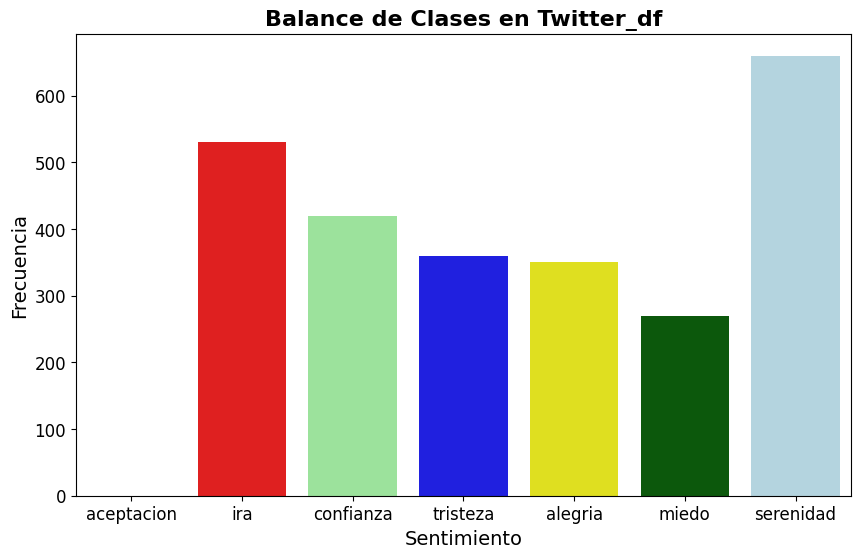

In [13]:
# Verificar el balance de clases en twitter_df
twitter_class_counts = twitter_selected['plutchik_sentiment'].value_counts()
print("\nConteo de clases en Twitter_df:")
print(twitter_class_counts)

# Graficar el balance de clases con colores personalizados
plt.figure(figsize=(10, 6))
sns.countplot(
    data=twitter_selected,
    x='plutchik_sentiment',
    palette=plutchik_palette,  # Usar la paleta personalizada
    order=plutchik_palette.keys()  # Ordenar según el diccionario
)

# Añadir título y etiquetas
plt.title('Balance de Clases en Twitter_df', fontsize=16, fontweight='bold')
plt.xlabel('Sentimiento', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# visualización de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar la gráfica
plt.show()


Conteo de clases en Travel_df:
plutchik_sentiment
confianza     15710
alegria        6023
aceptacion     2166
tristeza        695
ira             577
Name: count, dtype: int64


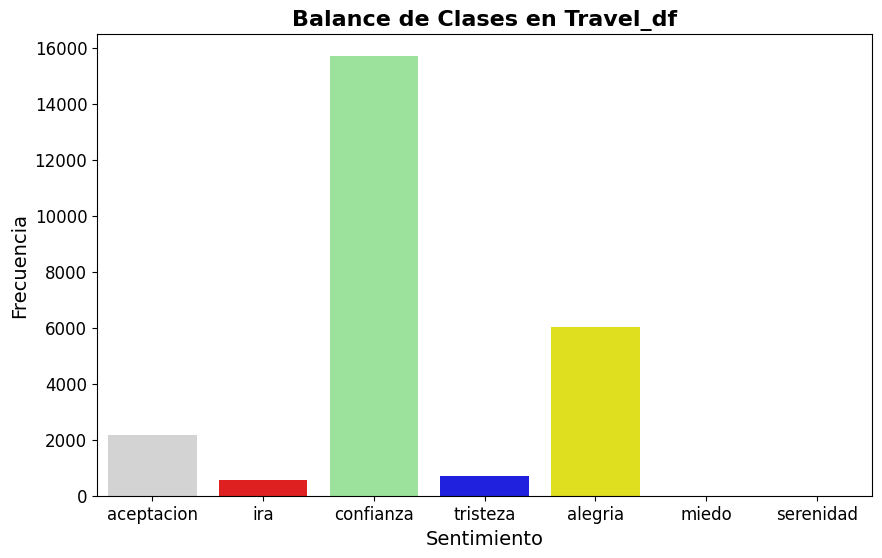

In [14]:
# Verificar el balance de clases en travel_df
travel_class_counts = travel_selected['plutchik_sentiment'].value_counts()
print("\nConteo de clases en Travel_df:")
print(travel_class_counts)

# Graficar el balance de clases con colores personalizados
plt.figure(figsize=(10, 6))
sns.countplot(
    data=travel_selected,
    x='plutchik_sentiment',
    palette=plutchik_palette,  # Usar la paleta personalizada
    order=plutchik_palette.keys()  # Ordenar según el diccionario
)

# Añadir título y etiquetas
plt.title('Balance de Clases en Travel_df', fontsize=16, fontweight='bold')
plt.xlabel('Sentimiento', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# visualización de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar la gráfica
plt.show()

In [15]:
int(travel_class_counts['ira'])

577

In [16]:
travel_alegria = travel_selected[travel_selected['plutchik_sentiment'] == 'alegria'].sample(n=travel_class_counts['ira'], random_state=42)
travel_tristeza = travel_selected[travel_selected['plutchik_sentiment'] == 'tristeza'].sample(n=travel_class_counts['ira'], random_state=42)
travel_confianza = travel_selected[travel_selected['plutchik_sentiment'] == 'confianza'].sample(n=travel_class_counts['ira'], random_state=42)
travel_aceptacion = travel_selected[travel_selected['plutchik_sentiment'] == 'aceptacion'].sample(n=travel_class_counts['ira'], random_state=42)

In [17]:
travel_selected = pd.concat([travel_alegria, travel_tristeza, travel_confianza, travel_aceptacion, travel_selected[travel_selected['plutchik_sentiment'] == 'ira']], ignore_index=True)

In [18]:
travel_selected['plutchik_sentiment'].value_counts()

plutchik_sentiment
alegria       577
tristeza      577
confianza     577
aceptacion    577
ira           577
Name: count, dtype: int64

## Combinar los datasets

In [19]:
# Merge los dos datasets
merged_df = pd.concat([twitter_selected, travel_selected], ignore_index=True)

# Reset index
merged_df.reset_index(drop=True, inplace=True)

# Check merged dataset
print("\nIngformación Merged Dataset:")
print(merged_df.info())
print("\nPrimeras filas del Merged Dataset:")
merged_df.head()


Ingformación Merged Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5475 entries, 0 to 5474
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   post                5475 non-null   object
 1   sentiment           5475 non-null   object
 2   source              5475 non-null   object
 3   plutchik_sentiment  5475 non-null   object
dtypes: object(4)
memory usage: 171.2+ KB
None

Primeras filas del Merged Dataset:


,post,sentiment,source,plutchik_sentiment
0,termine bien abrumado después de hoy,scared,Twitter,miedo
1,me siento abrumado,scared,Twitter,miedo
2,Me siento un poco abrumado por la cantidad de ...,scared,Twitter,miedo
3,Salvador la única persona que no la ha abrumad...,scared,Twitter,miedo
4,Denme un helado o algo que ando full abrumado.,scared,Twitter,miedo


## Funciones

In [20]:
def normalize_text(text):
    """
    Normalize text by:
    1. Removing special characters (keeping Spanish letters and accents)
    2. Removing words with characters repeated more than twice
    3. Joining hyphenated words
    4. Converting to lowercase
    5. Removing tildes and the letter "ñ"
    """
    if not isinstance(text, str):
        return ""
    
    # Remove tildes and the letter "ñ" using unidecode
    text = unidecode(text)
    
    # Remove special characters (keeping only letters and spaces)
    letters_only = re.sub(r"[^A-Za-z\s]", " ", text)
    
    # Remove repeated characters (more than 2 times)
    no_repeats = re.sub(r"(.)\1{2,}", r"\1\1", letters_only)
    
    # Join hyphenated words
    no_hyphens = re.sub(r"([A-Za-z]+)-([A-Za-z]+)", r"\1\2", no_repeats)
    
    # Convert to lowercase
    lowercase = no_hyphens.lower()
    
    # Remove extra whitespace
    cleaned = re.sub(r"\s+", " ", lowercase).strip()
    
    return cleaned

In [21]:
merged_df['normalized_text'] = merged_df['post'].apply(normalize_text)
print("\nEjemplos Normalizacion:")
for i in range(min(5, len(merged_df))):
    print(f"Original: {merged_df.loc[i, 'post']}")
    print(f"Normalizado: {merged_df.loc[i, 'normalized_text']}")
    print("-" * 50)


Ejemplos Normalizacion:
Original: termine bien abrumado después de hoy
Normalizado: termine bien abrumado despues de hoy
--------------------------------------------------
Original: me siento abrumado
Normalizado: me siento abrumado
--------------------------------------------------
Original: Me siento un poco abrumado por la cantidad de cosas que quiero dibujar, ver, jugar y leer. Odio esta sensación xdddd
Normalizado: me siento un poco abrumado por la cantidad de cosas que quiero dibujar ver jugar y leer odio esta sensacion xdd
--------------------------------------------------
Original: Salvador la única persona que no la ha abrumado de versiones❤😒❤ #NadieComoTú
Normalizado: salvador la unica persona que no la ha abrumado de versiones nadiecomotu
--------------------------------------------------
Original: Denme un helado o algo que ando full abrumado.
Normalizado: denme un helado o algo que ando full abrumado
--------------------------------------------------


In [22]:
def tokenize_text(text):
    """
    Tokenize text into individual words
    """
    if not isinstance(text, str) or not text:
        return []
    
    tokens = word_tokenize(text)
    return tokens

In [23]:
# Apply tokenization to the normalized text
merged_df['tokens'] = merged_df['normalized_text'].apply(tokenize_text)

# Show examples of tokenization
print("\nEjemplo Tokenizacion:")
for i in range(min(5, len(merged_df))):
    print(f"Normalized: {merged_df.loc[i, 'normalized_text']}")
    print(f"Tokens: {merged_df.loc[i, 'tokens']}")
    print("-" * 50)


Ejemplo Tokenizacion:
Normalized: termine bien abrumado despues de hoy
Tokens: ['termine', 'bien', 'abrumado', 'despues', 'de', 'hoy']
--------------------------------------------------
Normalized: me siento abrumado
Tokens: ['me', 'siento', 'abrumado']
--------------------------------------------------
Normalized: me siento un poco abrumado por la cantidad de cosas que quiero dibujar ver jugar y leer odio esta sensacion xdd
Tokens: ['me', 'siento', 'un', 'poco', 'abrumado', 'por', 'la', 'cantidad', 'de', 'cosas', 'que', 'quiero', 'dibujar', 'ver', 'jugar', 'y', 'leer', 'odio', 'esta', 'sensacion', 'xdd']
--------------------------------------------------
Normalized: salvador la unica persona que no la ha abrumado de versiones nadiecomotu
Tokens: ['salvador', 'la', 'unica', 'persona', 'que', 'no', 'la', 'ha', 'abrumado', 'de', 'versiones', 'nadiecomotu']
--------------------------------------------------
Normalized: denme un helado o algo que ando full abrumado
Tokens: ['denme', 'un',

In [24]:
def remove_stopwords(tokens):
    """
    Remove Spanish stopwords from a list of tokens
    """
    if not tokens:
        return []
    
    spanish_stopwords = set(stopwords.words('spanish'))
    filtered_tokens = [token for token in tokens if token not in spanish_stopwords]
    return filtered_tokens

In [25]:
# Apply stopword removal to the tokens
merged_df['filtered_tokens'] = merged_df['tokens'].apply(remove_stopwords)

# Show examples of stopword removal
print("\nEjemplos Remocion Stopword:")
for i in range(min(5, len(merged_df))):
    print(f"Tokens: {merged_df.loc[i, 'tokens']}")
    print(f"Despues de remover Stopword: {merged_df.loc[i, 'filtered_tokens']}")
    print("-" * 50)


Ejemplos Remocion Stopword:
Tokens: ['termine', 'bien', 'abrumado', 'despues', 'de', 'hoy']
Despues de remover Stopword: ['termine', 'bien', 'abrumado', 'despues', 'hoy']
--------------------------------------------------
Tokens: ['me', 'siento', 'abrumado']
Despues de remover Stopword: ['siento', 'abrumado']
--------------------------------------------------
Tokens: ['me', 'siento', 'un', 'poco', 'abrumado', 'por', 'la', 'cantidad', 'de', 'cosas', 'que', 'quiero', 'dibujar', 'ver', 'jugar', 'y', 'leer', 'odio', 'esta', 'sensacion', 'xdd']
Despues de remover Stopword: ['siento', 'abrumado', 'cantidad', 'cosas', 'quiero', 'dibujar', 'ver', 'jugar', 'leer', 'odio', 'sensacion', 'xdd']
--------------------------------------------------
Tokens: ['salvador', 'la', 'unica', 'persona', 'que', 'no', 'la', 'ha', 'abrumado', 'de', 'versiones', 'nadiecomotu']
Despues de remover Stopword: ['salvador', 'unica', 'persona', 'abrumado', 'versiones', 'nadiecomotu']
------------------------------------

In [26]:
try:
    nlp = spacy.load('es_core_news_sm')
except:
    # If model not found, download it
    import sys
    !{sys.executable} -m spacy download es_core_news_sm
    nlp = spacy.load('es_core_news_sm')

def lemmatize_tokens(tokens):
    """
    Lemmatize a list of tokens using spaCy's Spanish model
    """
    if not tokens:
        return []
    
    # Join tokens back into text for spaCy processing
    text = ' '.join(tokens)
    doc = nlp(text)
    
    # Extract lemmas
    lemmas = [token.lemma_.lower() for token in doc if token.lemma_.strip()]
    
    return lemmas

In [27]:
# Inicializar el lematizador de NLTK
# lemmatizer = WordNetLemmatizer()

# # Función para convertir etiquetas POS de NLTK a WordNet
# def get_wordnet_pos(treebank_tag):
#     """
#     Mapea las etiquetas POS de NLTK a las etiquetas POS de WordNet.
#     """
#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN  # Por defecto, asumimos sustantivo

# def lemmatize_tokens(tokens):
#     """
#     Lemmatiza una lista de tokens usando NLTK.
#     """
#     if not tokens:
#         return []
    
#     # Obtener las etiquetas POS de los tokens
#     pos_tags = nltk.pos_tag(tokens)
    
#     # Lematizar cada token con su etiqueta POS correspondiente
#     lemmas = []
#     for token, pos_tag in pos_tags:
#         wordnet_pos = get_wordnet_pos(pos_tag)
#         lemma = lemmatizer.lemmatize(token, pos=wordnet_pos)
#         lemmas.append(lemma.lower())
    
#     return lemmas

In [28]:
# Apply lemmatization to the filtered tokens
merged_df['lemmas'] = merged_df['filtered_tokens'].apply(lemmatize_tokens)

# Show examples of lemmatization
print("\nEjemplos Lemmatizacion:")
for i in range(min(5, len(merged_df))):
    print(f"Tokens: {merged_df.loc[i, 'filtered_tokens']}")
    print(f"Lemmas: {merged_df.loc[i, 'lemmas']}")
    print("-" * 50)


Ejemplos Lemmatizacion:
Tokens: ['termine', 'bien', 'abrumado', 'despues', 'hoy']
Lemmas: ['terminar', 'bien', 'abrumado', 'despu', 'hoy']
--------------------------------------------------
Tokens: ['siento', 'abrumado']
Lemmas: ['sentir', 'abrumado']
--------------------------------------------------
Tokens: ['siento', 'abrumado', 'cantidad', 'cosas', 'quiero', 'dibujar', 'ver', 'jugar', 'leer', 'odio', 'sensacion', 'xdd']
Lemmas: ['sentir', 'abrumado', 'cantidad', 'cosa', 'querer', 'dibujar', 'ver', 'jugar', 'leer', 'odio', 'sensacion', 'xdd']
--------------------------------------------------
Tokens: ['salvador', 'unica', 'persona', 'abrumado', 'versiones', 'nadiecomotu']
Lemmas: ['salvador', 'unico', 'persona', 'abrumado', 'versión', 'nadiecomotu']
--------------------------------------------------
Tokens: ['denme', 'helado', 'ando', 'full', 'abrumado']
Lemmas: ['denmir', 'helado', 'ar', 'full', 'abrumado']
--------------------------------------------------


In [29]:
# Combinar lemmas en un solo string para cada fila
merged_df['clean_text'] = merged_df['lemmas'].apply(lambda x: ' '.join(x) if x else '')

\Generando Word Cloud para los Textos:


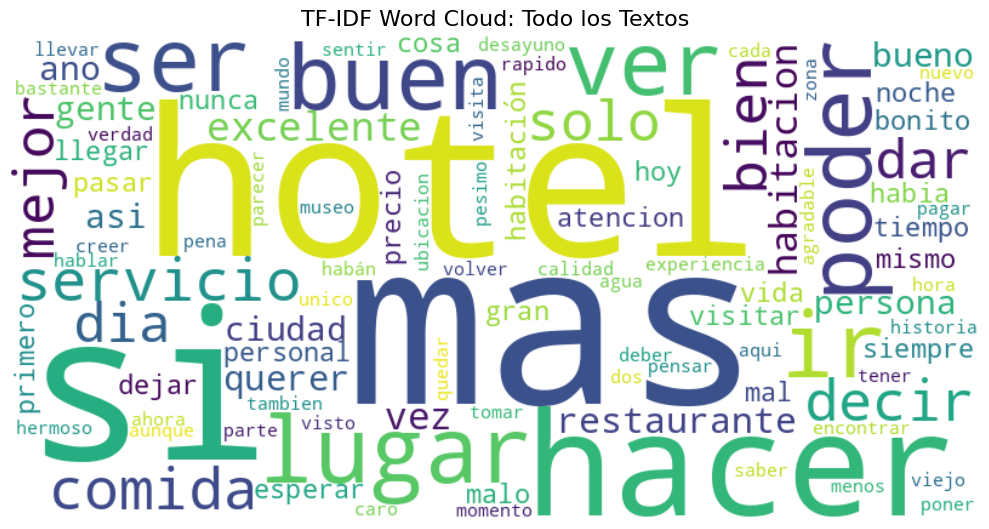

In [30]:
# Create a TF-IDF word cloud for each sentiment category

# Create a function to generate word clouds from TF-IDF values
def generate_tfidf_wordcloud(texts, title, max_words=100):
    """
    Generate a word cloud based on TF-IDF values for a collection of texts
    """
    # Create a TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=1000,
        stop_words=stopwords.words('spanish'),
        ngram_range=(1, 2)  # Include both single words and bigrams
    )
    
    # Fit and transform the texts
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    
    # Get feature names and their TF-IDF scores
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Sum TF-IDF values across documents for each word
    tfidf_sum = np.array(tfidf_matrix.sum(axis=0)).flatten()
    
    # Create a dictionary of word -> TF-IDF score
    word_tfidf = {feature_names[i]: tfidf_sum[i] for i in range(len(feature_names))}
    
    # Create and display word cloud
    plt.figure(figsize=(10, 6))
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        contour_width=1,
        contour_color='steelblue'
    ).generate_from_frequencies(word_tfidf)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate a word cloud for all texts
print("\Generando Word Cloud para los Textos:")
all_texts = merged_df['clean_text'].tolist()
generate_tfidf_wordcloud(all_texts, 'TF-IDF Word Cloud: Todo los Textos')


Generando Word Clouds por Categorias de Sentimiento:


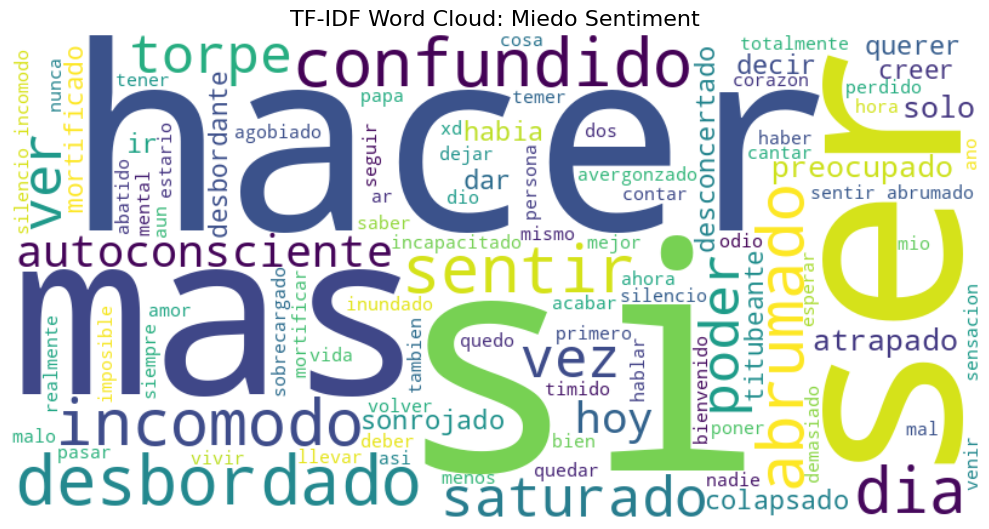

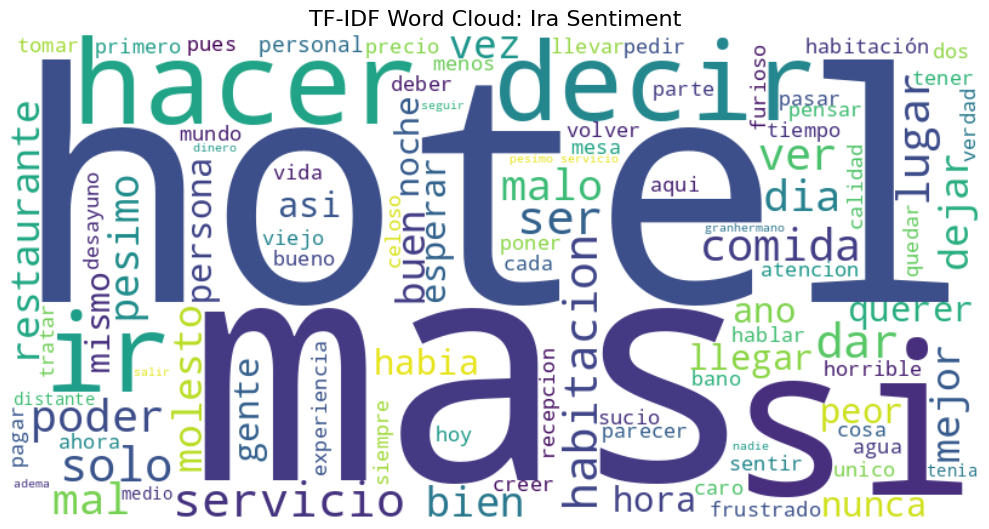

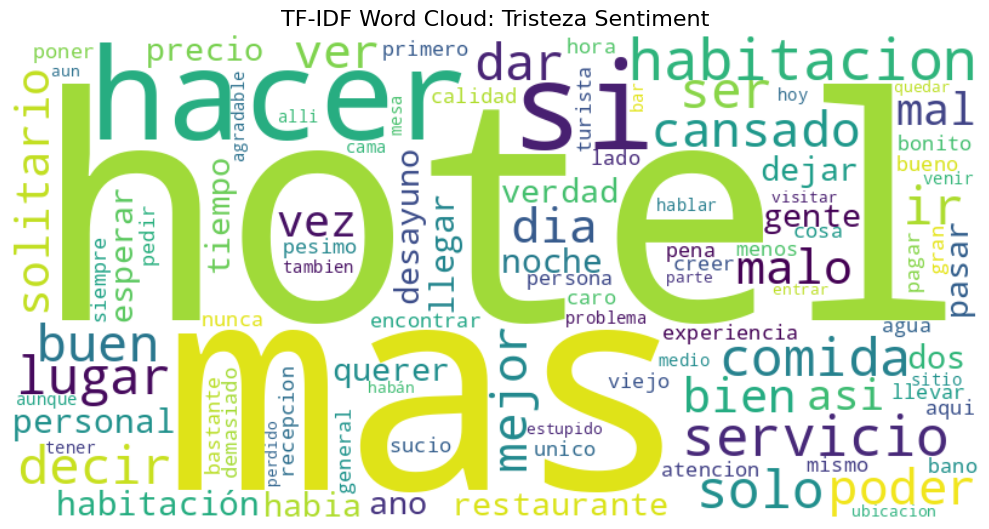

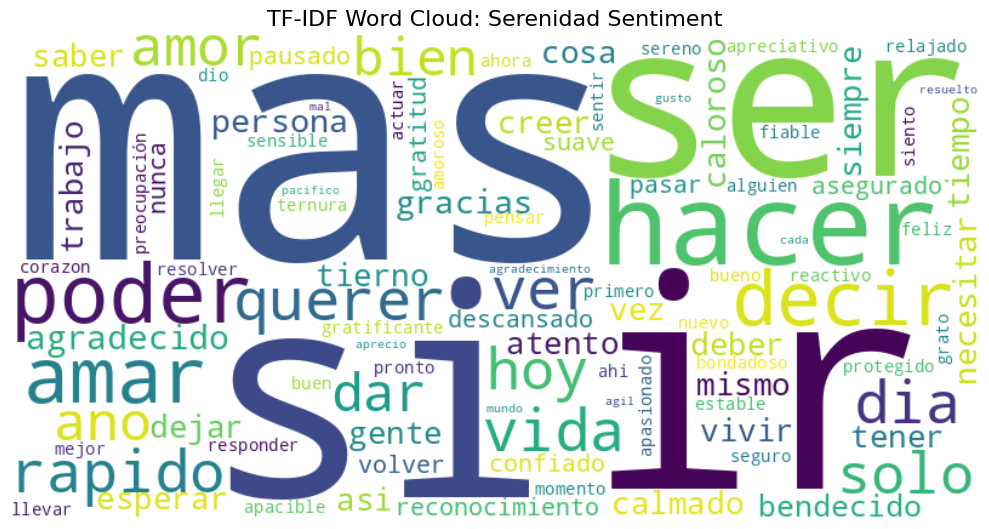

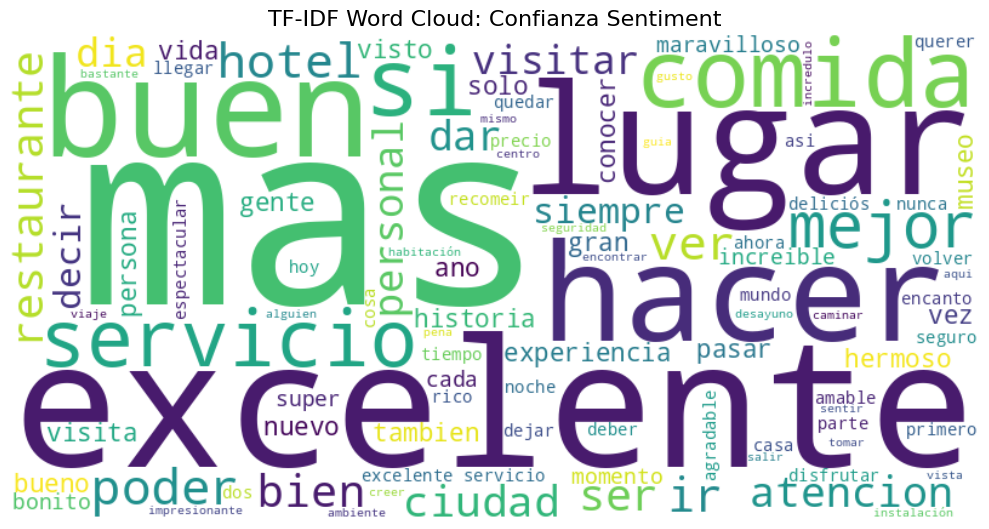

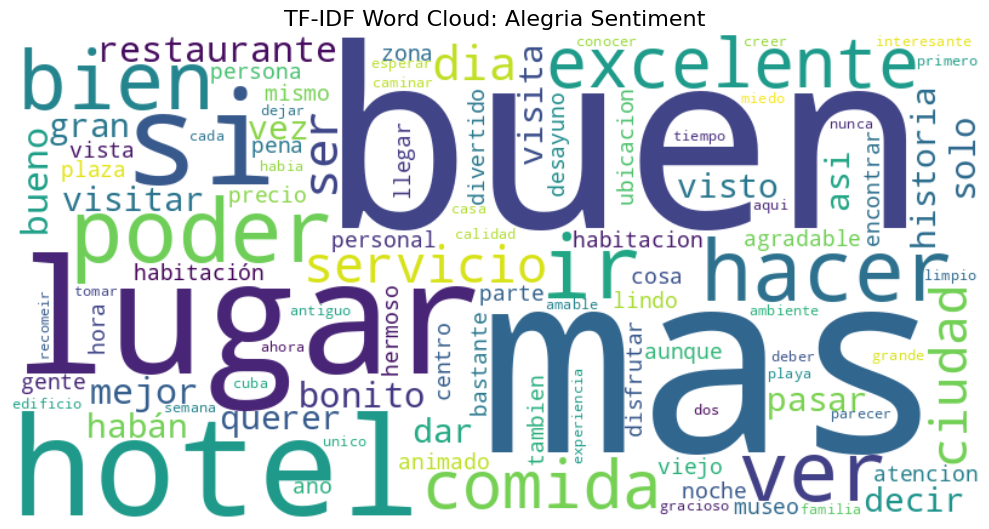

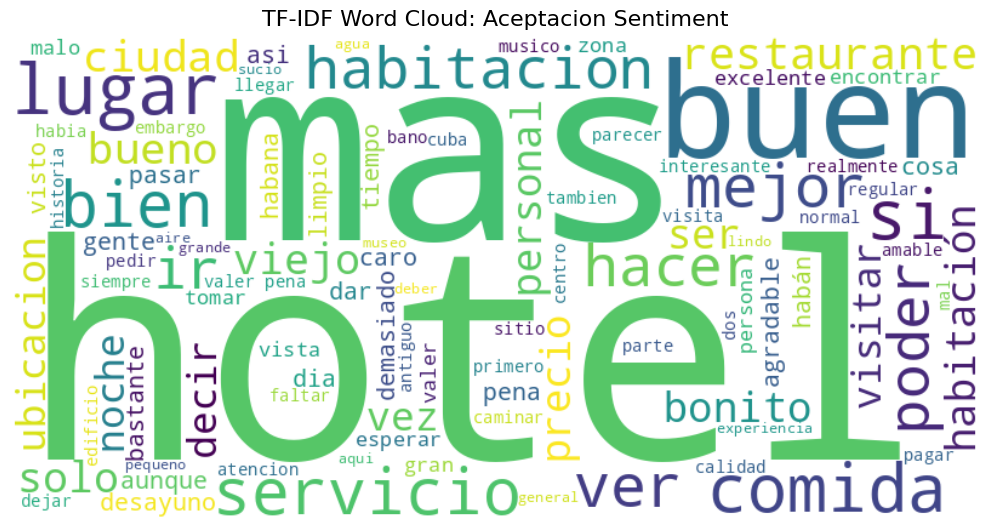

In [31]:
# Generate word clouds for each sentiment category
print("\nGenerando Word Clouds por Categorias de Sentimiento:")
for sentiment in merged_df['plutchik_sentiment'].dropna().unique():
    sentiment_texts = merged_df[merged_df['plutchik_sentiment'] == sentiment]['clean_text'].dropna().tolist()
    if sentiment_texts:
        generate_tfidf_wordcloud(sentiment_texts, f'TF-IDF Word Cloud: {sentiment.title()} Sentiment')

In [32]:
# Final processed dataset summary
print("\nResumen Final")
print(f"Numero total de post: {len(merged_df)}")
print(f"Numero de post por fuente: {merged_df['source'].value_counts().to_dict()}")
print(f"Numero de post por sentimiento: {merged_df['plutchik_sentiment'].value_counts().to_dict()}")


Resumen Final
Numero total de post: 5475
Numero de post por fuente: {'Review': 2885, 'Twitter': 2590}
Numero de post por sentimiento: {'ira': 1107, 'confianza': 997, 'tristeza': 937, 'alegria': 927, 'serenidad': 660, 'aceptacion': 577, 'miedo': 270}


In [33]:
merged_df.head()

,post,sentiment,source,plutchik_sentiment,normalized_text,tokens,filtered_tokens,lemmas,clean_text
0,termine bien abrumado después de hoy,scared,Twitter,miedo,termine bien abrumado despues de hoy,"[termine, bien, abrumado, despues, de, hoy]","[termine, bien, abrumado, despues, hoy]","[terminar, bien, abrumado, despu, hoy]",terminar bien abrumado despu hoy
1,me siento abrumado,scared,Twitter,miedo,me siento abrumado,"[me, siento, abrumado]","[siento, abrumado]","[sentir, abrumado]",sentir abrumado
2,Me siento un poco abrumado por la cantidad de ...,scared,Twitter,miedo,me siento un poco abrumado por la cantidad de ...,"[me, siento, un, poco, abrumado, por, la, cant...","[siento, abrumado, cantidad, cosas, quiero, di...","[sentir, abrumado, cantidad, cosa, querer, dib...",sentir abrumado cantidad cosa querer dibujar v...
3,Salvador la única persona que no la ha abrumad...,scared,Twitter,miedo,salvador la unica persona que no la ha abrumad...,"[salvador, la, unica, persona, que, no, la, ha...","[salvador, unica, persona, abrumado, versiones...","[salvador, unico, persona, abrumado, versión, ...",salvador unico persona abrumado versión nadiec...
4,Denme un helado o algo que ando full abrumado.,scared,Twitter,miedo,denme un helado o algo que ando full abrumado,"[denme, un, helado, o, algo, que, ando, full, ...","[denme, helado, ando, full, abrumado]","[denmir, helado, ar, full, abrumado]",denmir helado ar full abrumado


In [34]:
# Save the processed dataset to a CSV file
processed_file_path = 'Data/processed_sentiment_data.csv'
merged_df.to_csv(processed_file_path, index=False)
print(f"\nGuardado como: {processed_file_path}")


Guardado como: Data/processed_sentiment_data.csv


# Redes Neuronales

In [35]:
# Split
X = merged_df['clean_text']
X

0                        terminar bien abrumado despu hoy
1                                         sentir abrumado
2       sentir abrumado cantidad cosa querer dibujar v...
3       salvador unico persona abrumado versión nadiec...
4                          denmir helado ar full abrumado
                              ...                        
5470    pesimar atencion pesimo limpieza recepcionista...
5471    pesimo servicio mal servicio respetar cupón de...
5472    menos este buscar comprar multipropiedad merec...
5473    servia teleferico alla llegar decir teleferico...
5474    buena vacación hotel pequeno nuevo vallarta li...
Name: clean_text, Length: 5475, dtype: object

In [36]:
y = merged_df['plutchik_sentiment']
y

0       miedo
1       miedo
2       miedo
3       miedo
4       miedo
        ...  
5470      ira
5471      ira
5472      ira
5473      ira
5474      ira
Name: plutchik_sentiment, Length: 5475, dtype: object

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words=stopwords.words('spanish'),
    ngram_range=(1, 2)  # Include both single words and bigrams
)
# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)